#### Step 1: Data acquisition + cleanup


In [136]:
import pandas as pd
df = pd.read_csv("TIMES.csv")

In [137]:
# throw away everything except for the m_label field and the pixel values which are scattered across 400 columns labeled rxcy
def prepareDF(dataframe):
    df = dataframe.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'])
    return df

df = prepareDF(df)

In [138]:
import numpy as np

def normalize_X_and_y(dataframe):
    #filters 'm_label' to include only ASCII chars that are common printable characters (from ASCII 34 to 125).
    df1 = dataframe[dataframe['m_label'] > 33]
    df = df1[df1['m_label'] < 126]
    yArray = np.array(df['m_label']) #Extracts the 'm_label' into a NumPy array

    #Feature array
    temp_dataframe = df.drop(columns=['m_label'])
    xArray = np.zeros((len(temp_dataframe), 20, 20))
    for row in range(0, temp_dataframe.shape[0]):
        for i in range(20):
            for j in range(20):
                string = 'r' + str(i) + 'c' + str(j)
                # normalization is done by dividing each pixel value by 255, scaling the pixel values to a range of 0 to 1
                xArray[row, i, j] = temp_dataframe.iloc[row].loc[string] /255
    
    
    return xArray, yArray

xVals, yVals = normalize_X_and_y(df)


In [139]:
def getAsciiDictionaries(yValues):
    unique_vals = set(yValues)
    setSize = len(unique_vals)
    index_to_ascii = {}
    ascii_to_index = {}
    index = 0
    for val in unique_vals:
        ascii_to_index[val] = index
        index_to_ascii[index] = val
        index+=1

    print(index_to_ascii)
    print(ascii_to_index)
    return ascii_to_index, index_to_ascii, setSize

asciiToIndex, indexToAscii, setSize = getAsciiDictionaries(yVals)


{0: np.int64(34), 1: np.int64(35), 2: np.int64(36), 3: np.int64(37), 4: np.int64(38), 5: np.int64(39), 6: np.int64(40), 7: np.int64(41), 8: np.int64(42), 9: np.int64(43), 10: np.int64(44), 11: np.int64(45), 12: np.int64(46), 13: np.int64(47), 14: np.int64(48), 15: np.int64(49), 16: np.int64(50), 17: np.int64(51), 18: np.int64(52), 19: np.int64(53), 20: np.int64(54), 21: np.int64(55), 22: np.int64(56), 23: np.int64(57), 24: np.int64(58), 25: np.int64(59), 26: np.int64(60), 27: np.int64(61), 28: np.int64(62), 29: np.int64(63), 30: np.int64(64), 31: np.int64(65), 32: np.int64(66), 33: np.int64(67), 34: np.int64(68), 35: np.int64(69), 36: np.int64(70), 37: np.int64(71), 38: np.int64(72), 39: np.int64(73), 40: np.int64(74), 41: np.int64(75), 42: np.int64(76), 43: np.int64(77), 44: np.int64(78), 45: np.int64(79), 46: np.int64(80), 47: np.int64(81), 48: np.int64(82), 49: np.int64(83), 50: np.int64(84), 51: np.int64(85), 52: np.int64(86), 53: np.int64(87), 54: np.int64(88), 55: np.int64(89), 5

In [140]:
# Convert yValues array, which originally contains ASCII values, into indices using the ascii_to_index dictionary
def convertToIndex(yValues, ascii_to_index):
    for i in range(len(yValues)):
        yValues[i] = ascii_to_index[yValues[i]]

    return yValues

yVals = convertToIndex(yVals, asciiToIndex)


#### Step 2: Build a Pytorch network


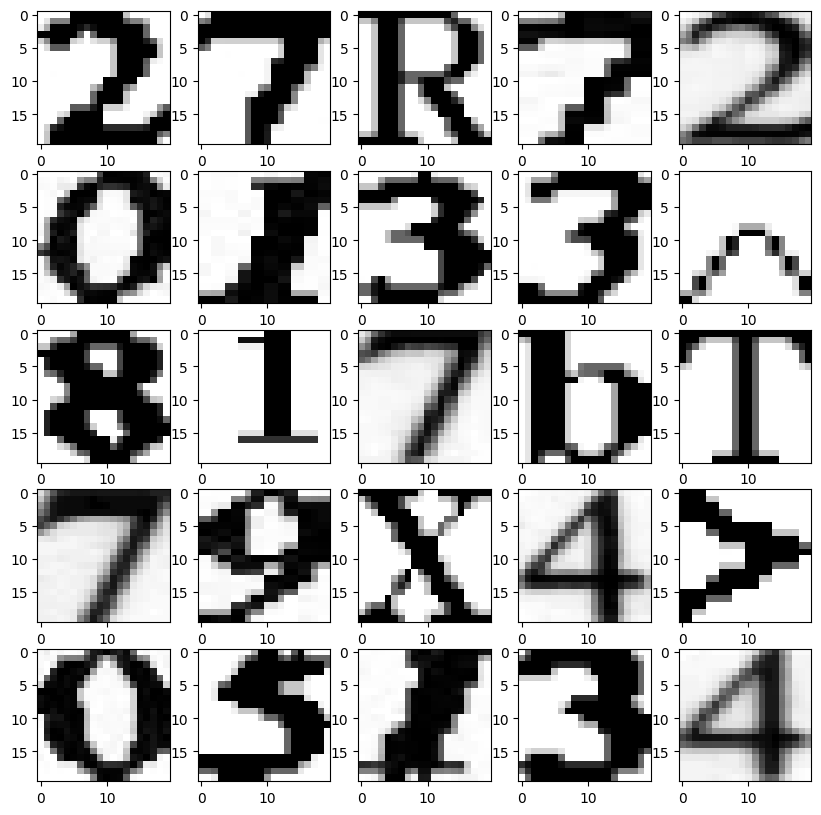

In [141]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

plt.figure( figsize= (10, 10) )

for i in np.arange( 25 ):
    plt.subplot( 5, 5, i+1 )
    plt.imshow( xVals[i, :, :], cmap='Greys',interpolation='none' )

plt.show()
Xs = np.reshape(xVals, (-1, 1, 20, 20))

In [142]:
#split the data into train/test
x_tensor = torch.tensor(Xs, dtype=torch.float32)
y_tensor = torch.tensor(yVals)

x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, random_state=1, test_size=0.9)

training_data = TensorDataset(x_train, y_train)
testing_data = TensorDataset(x_test, y_test)

In [143]:
class Net(nn.Module):
    #sets up the layers and components of the neural network
    def __init__(self):
        super(Net, self).__init__()
        # Set up 1st convolutional layer
        # Uses 6 filters, each w. kernel size of 3x3 pixels. 
        # The input has 1 channel (grayscale image). The output of this layer will be 6 feature maps
        self.conv1 = nn.Conv2d( 1, 6, 3 ) 
                
        self.pool = nn.MaxPool2d( 2, 2 ) # set up max pooling to be a 2x2 block
        
        # Set up 2nd convolutional layer
        # Uses 16 filters, each w. kernel size of 3x3 pixels. 
        # The input has 6 feature maps. The output of this layer will be 16 feature maps        
        self.conv2 = nn.Conv2d( 6, 16, 3 )
        
        # Set up 1st dense layer 
        # 3x3 grid per each of the 16 feature maps from conv2
        self.pooledOutputSize = 16 * 3 * 3 
        self.fc1 = nn.Linear( self.pooledOutputSize, 120 )
        
        #Set up 2nd and 3rd dense layers, which continue to refine the outputs towards the final classification layer
        self.fc2 = nn.Linear( 120, 84 )
        self.fc3 = nn.Linear( 84, setSize ) # predicts one of setSize classes (number of unique characters)

    #-------------------------------#
    # Take an image (or images) and run it through all stages of the net
    # input x is "batch" of images
    def forward( self, x ): 
        # Pass image through 1st convolution layer, activation fn, then max pool
        x = self.pool(F.relu(self.conv1(x))) 
        
        # Pass image through 2nd convolution layer, activation fn, then max pool
        x = self.pool(F.relu(self.conv2(x))) 

        # Prep image 2nd max pooling output to be 1D for dense layer
        x = x.view(-1, self.get_num_features(x))
        
        # 1D image is passed through 1st dense layer, then relu fn
        x = F.relu(self.fc1(x)) 
        # 2nd dense layer, then relu fn
        x = F.relu(self.fc2(x))
        #3rd dense layer, no activation function on this
        x = self.fc3(x) 
        return x
    
    #Calculate the total number of features in the tensor after the last pooling layer
    # (channels, height, width) multiplies them together to compute the total number of elements 
    # i.e 5X5 feature map * 16 maps = 400 
    def get_num_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()

In [144]:
# model: The neural network model to be trained.
# epochs: The number of complete passes through the entire dataset.
# training_data: The dataset used for training, which includes inputs and corresponding labels.
def train( model, epochs, training_data ): 
    
    # measure the error (loss) during training
    # Correct pred + high confidence = penalized less
    # incorrect pred + high confidence = penalized more
    criterion = nn.CrossEntropyLoss() 

    # use the ADAM optimizer to adjust the weights of the net to minimize the loss
    optimizer = optim.Adam( model.parameters(), lr= 1e-4 ) 
    
    # Load data and gets it in the correct format
    train_data_loader = torch.utils.data.DataLoader( training_data, batch_size=8,
                                               shuffle=True, num_workers=0 )

    # Iterates through the dataset as many times as specified 
    for epoch in range( epochs ): 

        running_loss = 0.0
        
        # Iterates through the data in batches as provided by trainloader
        for i, data in enumerate( train_data_loader, 0 ):
            # Extract data
            inputs = x_tensor
            labels = y_tensor
            # zero the previous gradients
            optimizer.zero_grad()

            # computes the predicted outputs using the current state of the model
            outputs = model(inputs) 
            # calculate the loss between the predictions and actual labels
            loss = criterion(outputs, labels) 

            # computes the gradient of the loss with respect to the model parameters (seeing what weights to get better results)
            loss.backward()
            optimizer.step() # update weights 
            
            # log loss for monitoring training progress
            running_loss += loss.item()
            if i % 2000 == 1999:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

In [145]:
print( "Training..." )
train( net, 15, training_data )

Training...
Finished Training


#### Step 3: Exploration and Evaluation


Evaluating...
Accuracy: 25 %


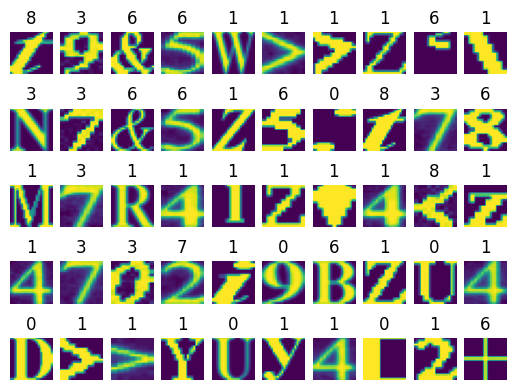

In [146]:
# model: The trained neural network model that needs evaluation.
# testing_data: The dataset used for testing the model.
# indexToAscii: A dictionary mapping from predicted indices to their corresponding ASCII characters, used for displaying misclassified characters.
def evaluate( model, testing_data, indexToAscii):  
    #load test data
    test_data = torch.utils.data.DataLoader( testing_data, batch_size=1,
                                              shuffle=True, num_workers=0 )
    correct = 0
    total = 0

    with torch.no_grad(): 
        incorrect = 0
        for data in test_data:
            images, labels = data
            outputs = model( images )
            # Extracts the class with the highest predicted score (confidence)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # If the prediction does not match the label, the misclassified image is visualized
            if predicted != labels:
                ascii = chr(indexToAscii[predicted.item()])
                plt.subplot(5,10, incorrect+1)
                plt.imshow(images[0,0])
                plt.title(ascii)
                plt.axis('off')
                
                incorrect+=1
                if incorrect >=50:
                    break

    # Coarse evaluation
    print( 'Accuracy: %d %%' % ( 100 * correct / total) )

print( "Evaluating..." )
evaluate( net, testing_data, indexToAscii )

**1. Evaluate the network using cross validation (splitting data into training/testing). What is its accuracy?**
54%


In [147]:
#Create and train a different network topology (add more convolution layers, experiment with normalization (batch normalization or dropout), explore other types/sizes of layer). Try to find a topology that works better than the one described above.
class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        c1Out = 16 
        c2Out = 32 
        c3Out = 32
        self.conv1 = nn.Conv2d( 1, c1Out, 3 ) 
        
        self.pool = nn.MaxPool2d( 2, 2 ) 
   
        self.conv2 = nn.Conv2d( c1Out, c2Out, 3 ) 

        self.conv3 = nn.Conv3d(c2Out, c3Out, 3)
        
        self.pooledOutputSize = c2Out * 3 * 3 
        self.fc1 = nn.Linear( self.pooledOutputSize, 120 )
        self.fc2 = nn.Linear( 120, 84 )
        self.fc3 = nn.Linear( 84, setSize ) 

    def forward( self, x ):
        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, self.get_num_flat_features(x))
       
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x) 
        return x
    
    def get_num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


newnet = NewNet()


Training...
Finished Training
Evaluating...
Accuracy: 74 %


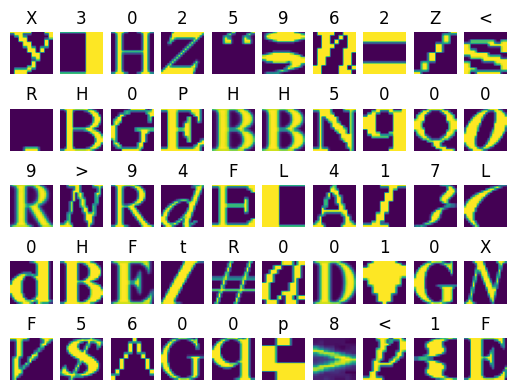

In [148]:
print( "Training..." )
train( newnet, 15, training_data)
print( "Evaluating..." )
evaluate( newnet, testing_data, indexToAscii )

In [149]:
# Load and prepare the SERIF.csv dataset
df_serif = pd.read_csv("SERIF.csv")
df_serif = prepareDF(df_serif)
xValsSerif, yValsSerif = normalize_X_and_y(df_serif)
ascii_to_index_serif, index_to_ascii_serif, setSize = getAsciiDictionaries(yValsSerif)
yValsSerif = convertToIndex(yValsSerif, ascii_to_index_serif)

# Reshape and convert to tensors
Xs_serif = np.reshape(xValsSerif, (-1, 1, 20, 20))
x_tensor_serif = torch.tensor(Xs_serif, dtype=torch.float32)
y_tensor_serif = torch.tensor(yValsSerif, dtype=torch.int64)  # Ensure correct data type for targets

# Split the data
x_train_serif, x_test_serif, y_train_serif, y_test_serif = train_test_split(
    x_tensor_serif, y_tensor_serif, random_state=1, test_size=0.9
)

# Create data loaders
training_data_serif = TensorDataset(x_train_serif, y_train_serif)
testing_data_serif = TensorDataset(x_test_serif, y_test_serif)
train_loader_serif = DataLoader(training_data_serif, batch_size=32, shuffle=True)
test_loader_serif = DataLoader(testing_data_serif, batch_size=1, shuffle=True)


{0: np.int64(34), 1: np.int64(35), 2: np.int64(36), 3: np.int64(37), 4: np.int64(38), 5: np.int64(39), 6: np.int64(40), 7: np.int64(41), 8: np.int64(42), 9: np.int64(43), 10: np.int64(44), 11: np.int64(45), 12: np.int64(46), 13: np.int64(47), 14: np.int64(48), 15: np.int64(49), 16: np.int64(50), 17: np.int64(51), 18: np.int64(52), 19: np.int64(53), 20: np.int64(54), 21: np.int64(55), 22: np.int64(56), 23: np.int64(57), 24: np.int64(58), 25: np.int64(59), 26: np.int64(60), 27: np.int64(61), 28: np.int64(62), 29: np.int64(63), 30: np.int64(64), 31: np.int64(65), 32: np.int64(66), 33: np.int64(67), 34: np.int64(68), 35: np.int64(69), 36: np.int64(70), 37: np.int64(71), 38: np.int64(72), 39: np.int64(73), 40: np.int64(74), 41: np.int64(75), 42: np.int64(76), 43: np.int64(77), 44: np.int64(78), 45: np.int64(79), 46: np.int64(80), 47: np.int64(81), 48: np.int64(82), 49: np.int64(83), 50: np.int64(84), 51: np.int64(85), 52: np.int64(86), 53: np.int64(87), 54: np.int64(88), 55: np.int64(89), 5

Training...
Finished Training
Evaluating...
Accuracy: 32 %


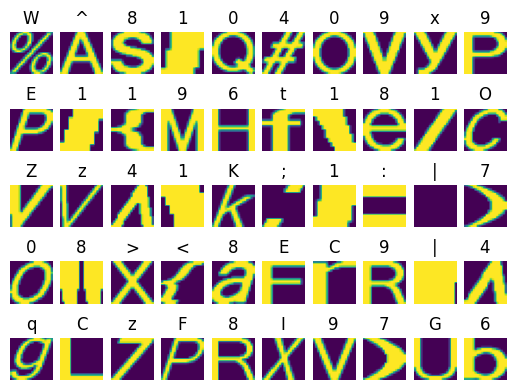

In [150]:
print( "Training..." )
train( newnet, 15, training_data_serif)
print( "Evaluating..." )
evaluate( newnet, testing_data_serif, index_to_ascii_serif)


My new NN had increased accuracy with the font 'TIMES' going from 54% to 73% accuracy. My new font 'SERIF' had a pretty low accuracy rate of 29% though, which isn't great. 

{0: np.int64(34), 1: np.int64(35), 2: np.int64(36), 3: np.int64(37), 4: np.int64(38), 5: np.int64(39), 6: np.int64(40), 7: np.int64(41), 8: np.int64(42), 9: np.int64(43), 10: np.int64(44), 11: np.int64(45), 12: np.int64(46), 13: np.int64(47), 14: np.int64(48), 15: np.int64(49), 16: np.int64(50), 17: np.int64(51), 18: np.int64(52), 19: np.int64(53), 20: np.int64(54), 21: np.int64(55), 22: np.int64(56), 23: np.int64(57), 24: np.int64(58), 25: np.int64(59), 26: np.int64(60), 27: np.int64(61), 28: np.int64(62), 29: np.int64(63), 30: np.int64(64), 31: np.int64(65), 32: np.int64(66), 33: np.int64(67), 34: np.int64(68), 35: np.int64(69), 36: np.int64(70), 37: np.int64(71), 38: np.int64(72), 39: np.int64(73), 40: np.int64(74), 41: np.int64(75), 42: np.int64(76), 43: np.int64(77), 44: np.int64(78), 45: np.int64(79), 46: np.int64(80), 47: np.int64(81), 48: np.int64(82), 49: np.int64(83), 50: np.int64(84), 51: np.int64(85), 52: np.int64(86), 53: np.int64(87), 54: np.int64(88), 55: np.int64(89), 5

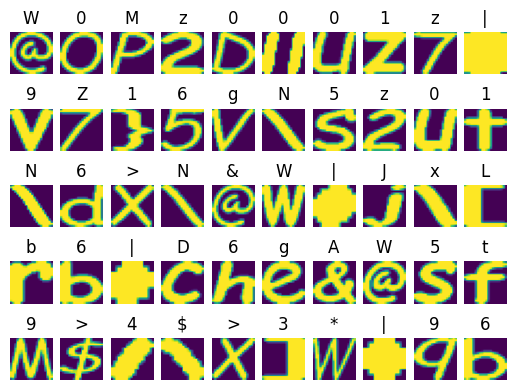

In [151]:
# Load and prepare the SERIF.csv dataset
df_comic = pd.read_csv("COMIC.csv")
df_comic = prepareDF(df_comic)
xValsComic, yValsComic = normalize_X_and_y(df_comic)
ascii_to_index_Comic, index_to_ascii_Comic, setSize = getAsciiDictionaries(yValsComic)
yValsComic = convertToIndex(yValsComic, ascii_to_index_Comic)

# Reshape and convert to tensors
Xs_Comic = np.reshape(xValsComic, (-1, 1, 20, 20))
x_tensor_Comic = torch.tensor(Xs_Comic, dtype=torch.float32)
y_tensor_Comic = torch.tensor(yValsComic, dtype=torch.int64)  # Ensure correct data type for targets

# Split the data
x_train_Comic, x_test_Comic, y_train_Comic, y_test_Comic = train_test_split(
    x_tensor_Comic, y_tensor_Comic, random_state=1, test_size=0.9
)

# Create data loaders
testing_data_Comic = TensorDataset(x_test_Comic, y_test_Comic)
test_loader_Comic = DataLoader(testing_data_serif, batch_size=1, shuffle=True)

print( "Evaluating..." )
evaluate( newnet, testing_data_Comic, index_to_ascii_Comic)

**What accuracy do you see when testing with inputs from a font you didn't train on?**
My 3rd font is 'COMIC' and with no testing I saw 28% accuracy, 1 percent less than training on with Serif. 

**Take a look at some of the characters that have been misclassified. Do you notice any patterns? The network only produces the relative probabilities that the input is any of the possible characters. Can you find examples where the network is unsure of the result?**

Common miss-classifications are numbers and symbols. This could be because of characters that look similar, such as '0' (zero) and 'O' (uppercase o), '1' (one), 'l' (lowercase L), and 'I' (uppercase i). Could be because special characters and symbols that may not appear as frequently in the training data, leading to poorer generalization by the model. Or the input character is noisy or distorted beyond what the model encountered during training

#### Step 4: Denoising

In [152]:
class CnnNet(nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()
        
        self.encodedSize = 32
        
        self.c1Out = 8 # filters from first conv layer
        self.c2Out = 8 # filters from 2nd conv layer
                
        self.cv1 = nn.Conv2d(1, self.c1Out, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.cv2 = nn.Conv2d(self.c1Out, self.c2Out, 3, padding=1)
        
        self.downscaledSize = 20//4 
        self.flattenedSize = self.downscaledSize*self.downscaledSize*self.c2Out
        
        self.fc1 = nn.Linear(self.flattenedSize, 64)
        self.fc2 = nn.Linear(64, self.encodedSize)
        
        # decompression 
        self.fc3 = nn.Linear(self.encodedSize, 64)
        self.fc4 = nn.Linear(64, self.flattenedSize)
        
        # Upsampling and Decoding Convolutional Layers
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.cv3 = nn.Conv2d(self.c2Out, self.c1Out, 3, padding=1)
        self.cv4 = nn.Conv2d(self.c1Out, 1, 3, padding=1)
        
    # Encoder     
    def compress(self, x):
        # c layer 1
        x = self.cv1(x)
        x = F.relu(self.pool(x))
        
        #c layer 2
        x = self.cv2(x)
        x = F.relu(self.pool(x))
        
        x = x.view(-1, self.flattenedSize) #flatten 
        
        #dense layer 1 and 2
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
    #Decode 
    def decompress(self, x):
        # 1st mapping of the encoded low-dimensional data back to a higher-dimensional space.
        x = F.relu(self.fc3(x))
        
        # 2nd mapping
        x = F.relu(self.fc4(x))
        
        # reshape from a flat vector into a 3D feature map format
        x = x.view(-1, self.c2Out, self.downscaledSize, self.downscaledSize)
        
        #reversing the effect of pooling in the encoder
        x = self.upsample(x)
        
        x = F.relu(self.cv3(x))
        x = self.cv4(self.upsample(x))
        return x
    
    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)
        return x

cnnNet = CnnNet() 


criterion = nn.MSELoss()

def trainCNN(model, epochs, train_data):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True, num_workers=0)
    
    for epoch in range(epochs):
        loss = 0
        
        running_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            batch_features = data[0]
        
            optimizer.zero_grad()
        
            # compute reconstructions
            outputs = model(batch_features)
           
            train_loss = criterion(outputs, batch_features)
        
            # compute accumulated gradients
            train_loss.backward()
        
            # perform parameter update based on current gradients
            optimizer.step()
        
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
    
            # print statistics
            running_loss += train_loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

        # compute the epoch training loss
        loss = loss / len(train_loader)
    
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.8f}".format(epoch + 1, epochs, loss))

def evaluateCNN(model, test_data):
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True, num_workers=0)
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images = data[0]
            outputs = model(images)
            test_loss = criterion(outputs, images)
            total_loss += test_loss.item()

    print("overall loss: ", total_loss)



def drawComparisonsCNN(model, test_data):
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True, num_workers=0)
    plt.figure(figsize=(20, 25))
    for i, batch in enumerate(test_loader):
        if i >= 8: break
        images = batch[0]
        #print(images.shape)
        with torch.no_grad():
            reconstructed = model(images)
            for j in range(len(images)):
                #draw the original image
                ax = plt.subplot(32, 16, i*32 + j + 1)
                plt.imshow(images[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            
                #and the reconstructed version in the next row
                ax = plt.subplot(32, 16, i*32 + j + 1 + 16)
                plt.imshow(reconstructed[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                
                if j > 0:  # Starting from the second image
                    diff = torch.sum(reconstructed[j] - reconstructed[0])
                    if diff.item() == 0:
                        print(f"Images at index 0 and {j} are identical post reconstruction.")
        

In [153]:
df_pre_sound = pd.read_csv("SERIF.csv")
df_pre_sound = prepareDF(df_pre_sound)
xValSound, yValSound = normalize_X_and_y(df_pre_sound)

ascii_to_index_sound, index_to_ascii_sound, setSize = getAsciiDictionaries(yValSound)
Ys = convertToIndex(yValSound, ascii_to_index_sound)

#add sound
noise_to_add = np.random.normal(0,.1,xValSound.shape)
xValSound = xValSound + noise_to_add

Xs_sound = np.reshape(xValSound, (-1, 1, 20, 20))

x_tensor_sound = torch.tensor(Xs_sound, dtype=torch.float32)
y_tensor_sound = torch.tensor(Ys)

x_train_sound, x_test_sound, y_train_sound, y_test_sound = train_test_split(x_tensor_sound, y_tensor_sound, random_state=1, test_size=0.9)

training_data_sound = TensorDataset(x_train_sound, y_train_sound)
testing_data_sound = TensorDataset(x_test_sound, y_test_sound)

{0: np.int64(34), 1: np.int64(35), 2: np.int64(36), 3: np.int64(37), 4: np.int64(38), 5: np.int64(39), 6: np.int64(40), 7: np.int64(41), 8: np.int64(42), 9: np.int64(43), 10: np.int64(44), 11: np.int64(45), 12: np.int64(46), 13: np.int64(47), 14: np.int64(48), 15: np.int64(49), 16: np.int64(50), 17: np.int64(51), 18: np.int64(52), 19: np.int64(53), 20: np.int64(54), 21: np.int64(55), 22: np.int64(56), 23: np.int64(57), 24: np.int64(58), 25: np.int64(59), 26: np.int64(60), 27: np.int64(61), 28: np.int64(62), 29: np.int64(63), 30: np.int64(64), 31: np.int64(65), 32: np.int64(66), 33: np.int64(67), 34: np.int64(68), 35: np.int64(69), 36: np.int64(70), 37: np.int64(71), 38: np.int64(72), 39: np.int64(73), 40: np.int64(74), 41: np.int64(75), 42: np.int64(76), 43: np.int64(77), 44: np.int64(78), 45: np.int64(79), 46: np.int64(80), 47: np.int64(81), 48: np.int64(82), 49: np.int64(83), 50: np.int64(84), 51: np.int64(85), 52: np.int64(86), 53: np.int64(87), 54: np.int64(88), 55: np.int64(89), 5

In [154]:
trainCNN(cnnNet, 15, training_data_sound)
evaluateCNN(cnnNet, testing_data_sound)

epoch : 1/15, loss = 0.46901365
epoch : 2/15, loss = 0.45365649
epoch : 3/15, loss = 0.43622547
epoch : 4/15, loss = 0.38932304
epoch : 5/15, loss = 0.32118180
epoch : 6/15, loss = 0.25487480
epoch : 7/15, loss = 0.24052666
epoch : 8/15, loss = 0.23566461
epoch : 9/15, loss = 0.22604496
epoch : 10/15, loss = 0.22274875
epoch : 11/15, loss = 0.21632726
epoch : 12/15, loss = 0.21825171
epoch : 13/15, loss = 0.21093615
epoch : 14/15, loss = 0.21121395
epoch : 15/15, loss = 0.20778450
overall loss:  8.489246129989624


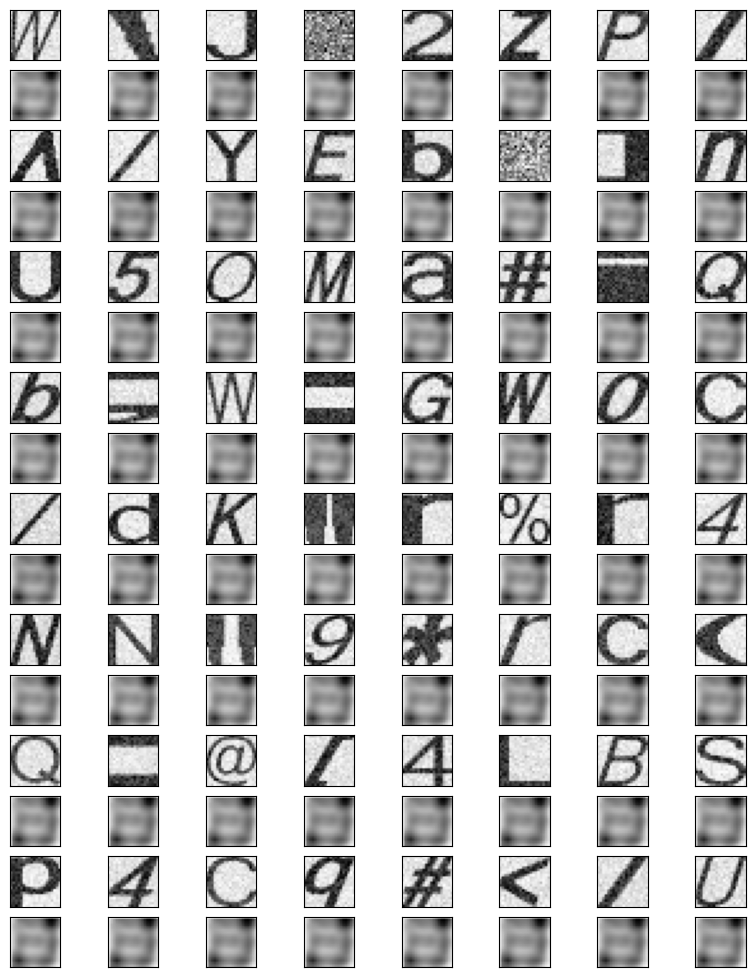

In [156]:
drawComparisonsCNN(cnnNet, testing_data_sound)